In [47]:
!pip install Sastrawi==1.0.1

In [48]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [49]:
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [50]:
# Load data
df = pd.read_csv('/kaggle/input/yt-comments/all_youtube_comments.csv')
df.head()

,comment
0,Transformasi digital adalah Mereparasi Otak Pa...
1,sangat bermanfaat
2,Wow
3,"Pak saya mau nanya, apakah transformasi digita..."
4,NaN


In [51]:
df['comment'] = df['comment'].fillna('').str.strip()
df = df[df['comment'] != '']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 88
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  85 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


In [52]:
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

In [53]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = stopword_remover.remove(text)  # Remove stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

In [54]:
df['clean_comments'] = df['comment'].apply(preprocess_text)

df['tokenized_comments'] = df['clean_comments'].apply(lambda x: x.split())

In [55]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_comments'])


sentences = df['tokenized_comments'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [56]:
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("TF-IDF Features:")
print(tfidf_features.head())

word2vec_features = df['tokenized_comments'].apply(
    lambda x: pd.Series([word2vec_model.wv[word] for word in x if word in word2vec_model.wv])
    .mean(axis=0)
).apply(pd.Series)
print("Word2Vec Features:")
print(word2vec_features.head())

TF-IDF Features:
   ada  adakarena  adalah  adanya  aduan  agent   ai  akan  akhirnya  akibat  \
0  0.0        0.0     0.0     0.0    0.0    0.0  0.0   0.0       0.0     0.0   
1  0.0        0.0     0.0     0.0    0.0    0.0  0.0   0.0       0.0     0.0   
2  0.0        0.0     0.0     0.0    0.0    0.0  0.0   0.0       0.0     0.0   
3  0.0        0.0     0.0     0.0    0.0    0.0  0.0   0.0       0.0     0.0   
4  0.0        0.0     0.0     0.0    0.0    0.0  0.0   0.0       0.0     0.0   

   ...   wa  waktu  wilayah  wisata  wkwk  wow  yaa  yaitu  yang   yg  
0  ...  0.0    0.0      0.0     0.0   0.0  0.0  0.0    0.0   0.0  0.0  
1  ...  0.0    0.0      0.0     0.0   0.0  0.0  0.0    0.0   0.0  0.0  
2  ...  0.0    0.0      0.0     0.0   0.0  1.0  0.0    0.0   0.0  0.0  
3  ...  0.0    0.0      0.0     0.0   0.0  0.0  0.0    0.0   0.0  0.0  
4  ...  0.0    0.0      0.0     0.0   0.0  0.0  0.0    0.0   0.0  0.0  

[5 rows x 818 columns]
Word2Vec Features:
         0         1       

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

In [58]:
def perform_clustering_and_evaluate(features, k_values):
    results = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        sil_score = silhouette_score(features, cluster_labels)
        results.append({'k': k, 'silhouette_score': sil_score})
        print(f"K: {k}, Silhouette Score: {sil_score:.4f}")
    return results

In [59]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [60]:
print("Clustering dengan TF-IDF:")
tfidf_results = perform_clustering_and_evaluate(tfidf_matrix.toarray(), k_values)

Clustering dengan TF-IDF:
K: 2, Silhouette Score: 0.0464
K: 3, Silhouette Score: 0.0588
K: 4, Silhouette Score: 0.0539
K: 5, Silhouette Score: 0.0428
K: 6, Silhouette Score: 0.0744
K: 7, Silhouette Score: 0.0464
K: 8, Silhouette Score: 0.0784
K: 9, Silhouette Score: 0.0644
K: 10, Silhouette Score: 0.0704


In [61]:
word2vec_features = word2vec_features.fillna(0)
print("\nClustering dengan Word2Vec:")
word2vec_results = perform_clustering_and_evaluate(word2vec_features.values, k_values)


Clustering dengan Word2Vec:
K: 2, Silhouette Score: 0.1543
K: 3, Silhouette Score: 0.1935
K: 4, Silhouette Score: 0.1894
K: 5, Silhouette Score: 0.2252
K: 6, Silhouette Score: 0.2305
K: 7, Silhouette Score: 0.2402
K: 8, Silhouette Score: 0.1536
K: 9, Silhouette Score: 0.2516
K: 10, Silhouette Score: 0.2651


In [62]:
tfidf_best_k = max(tfidf_results, key=lambda x: x['silhouette_score'])['k']
word2vec_best_k = max(word2vec_results, key=lambda x: x['silhouette_score'])['k']

print("\nHasil terbaik:")
print(f"TF-IDF: k={tfidf_best_k}, Silhouette Score={max(tfidf_results, key=lambda x: x['silhouette_score'])['silhouette_score']:.4f}")
print(f"Word2Vec: k={word2vec_best_k}, Silhouette Score={max(word2vec_results, key=lambda x: x['silhouette_score'])['silhouette_score']:.4f}")


Hasil terbaik:
TF-IDF: k=8, Silhouette Score=0.0784
Word2Vec: k=10, Silhouette Score=0.2651


In [63]:
tfidf_kmeans = KMeans(n_clusters=tfidf_best_k, random_state=42).fit(tfidf_matrix.toarray())
word2vec_kmeans = KMeans(n_clusters=word2vec_best_k, random_state=42).fit(word2vec_features.values)

In [64]:
df['tfidf_cluster'] = tfidf_kmeans.labels_
df['word2vec_cluster'] = word2vec_kmeans.labels_

In [65]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
def analyze_cluster_personas(data, cluster_col, text_col):
    cluster_personas = {}
    clusters = data[cluster_col].unique()

    for cluster in clusters:
        cluster_data = data[data[cluster_col] == cluster]
        all_text = ' '.join(cluster_data[text_col])
        word_counts = Counter(all_text.split())
        cluster_personas[cluster] = word_counts.most_common(10)  # Top 10 kata

        # Visualisasi WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {cluster}")
        plt.show()

    return cluster_personas

Persona Analysis untuk TF-IDF Clusters:


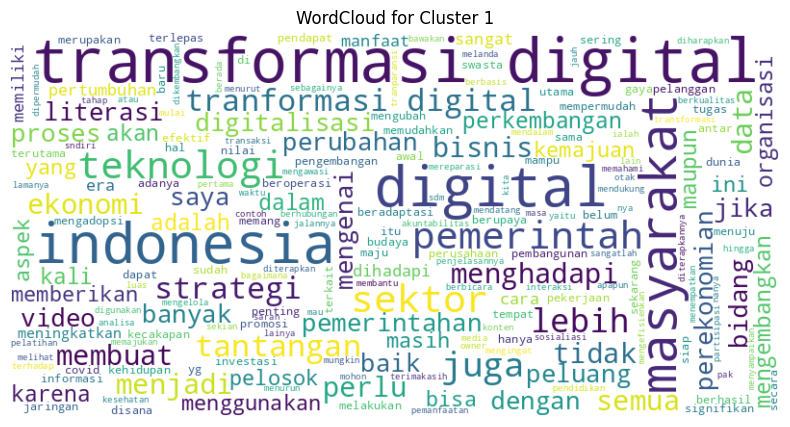

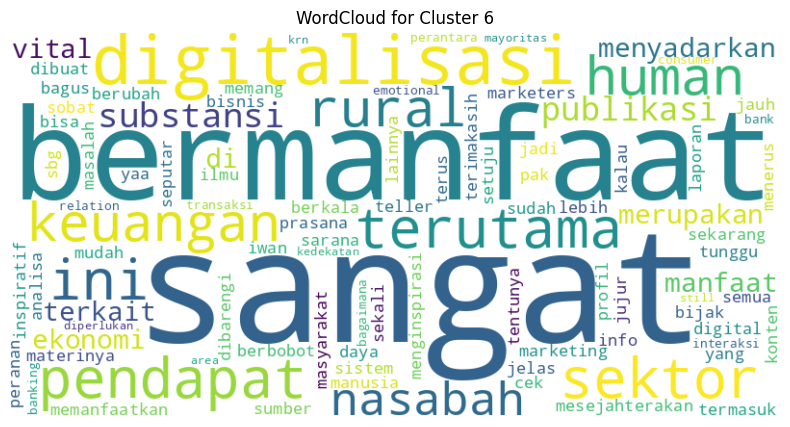

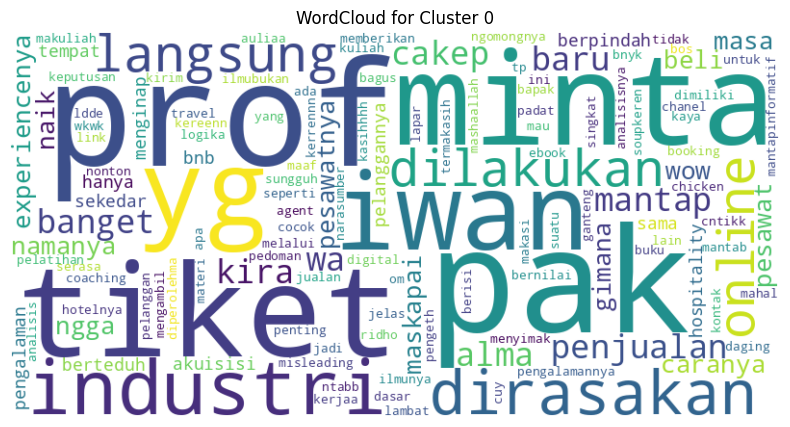

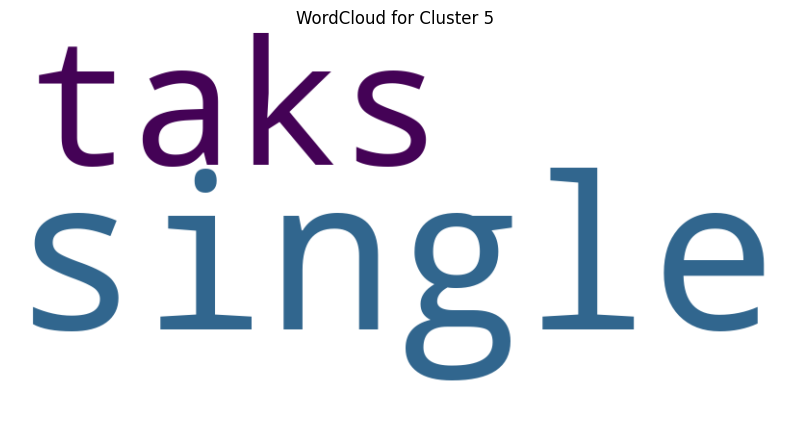

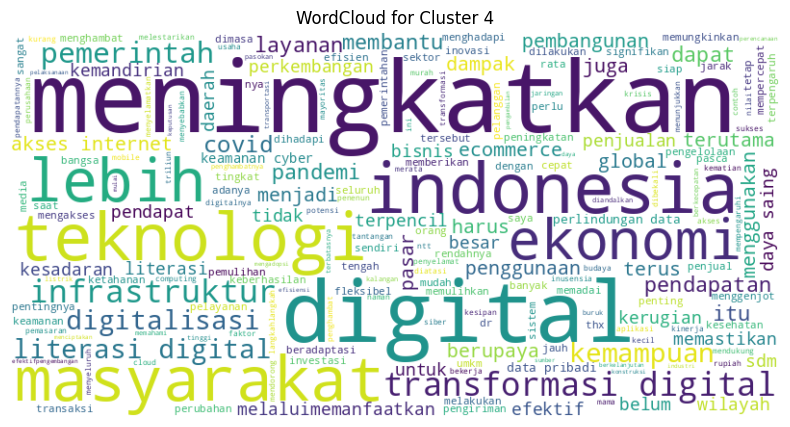

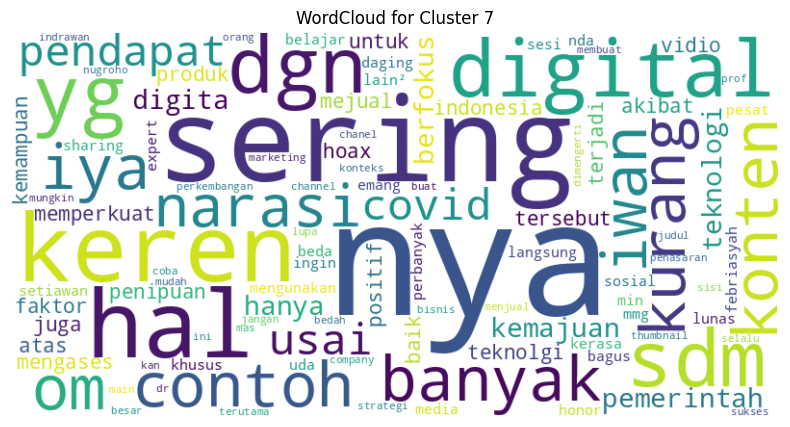

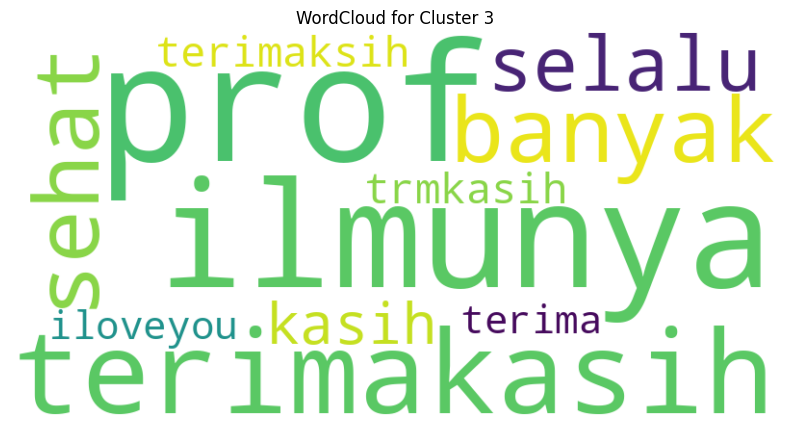

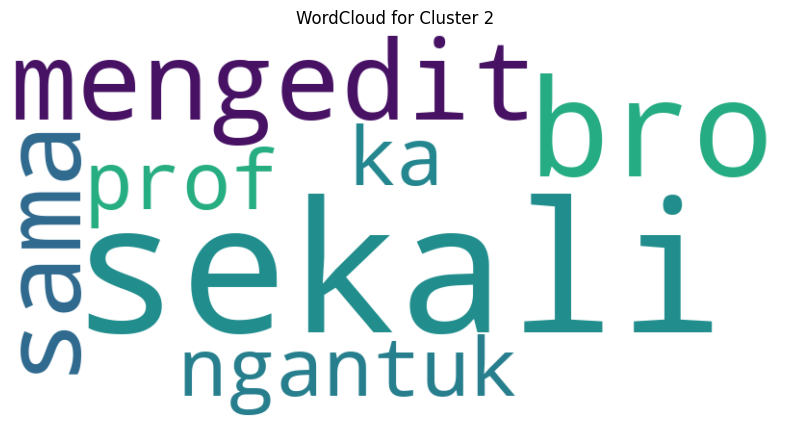


Persona Analysis untuk Word2Vec Clusters:


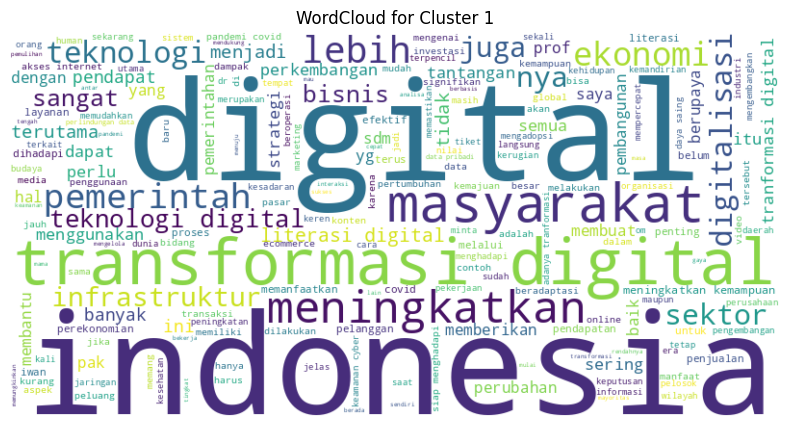

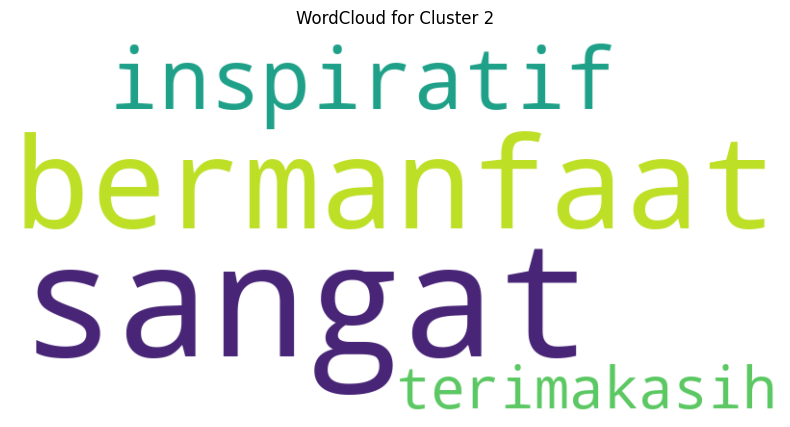

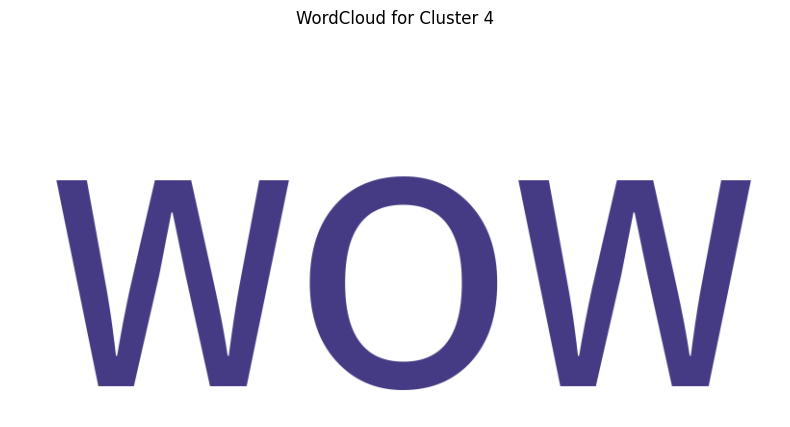

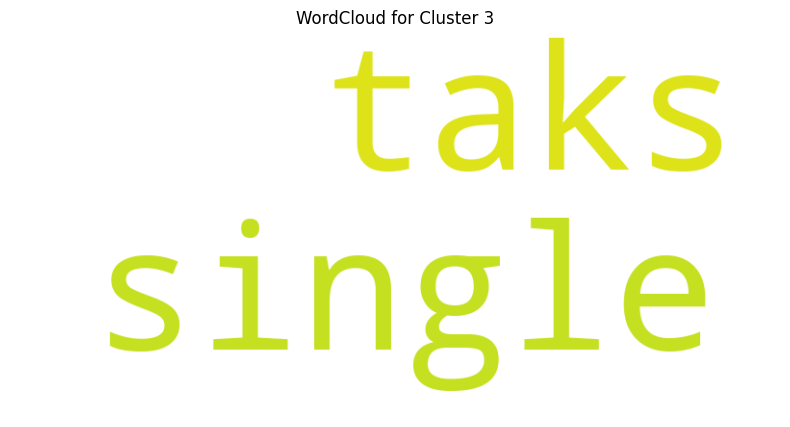

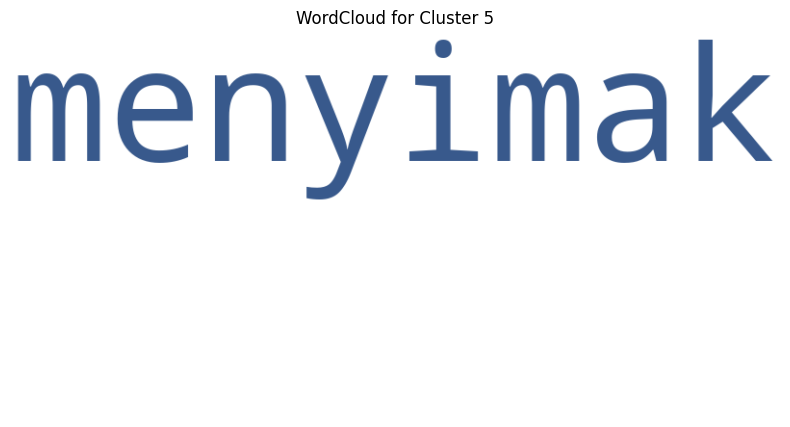

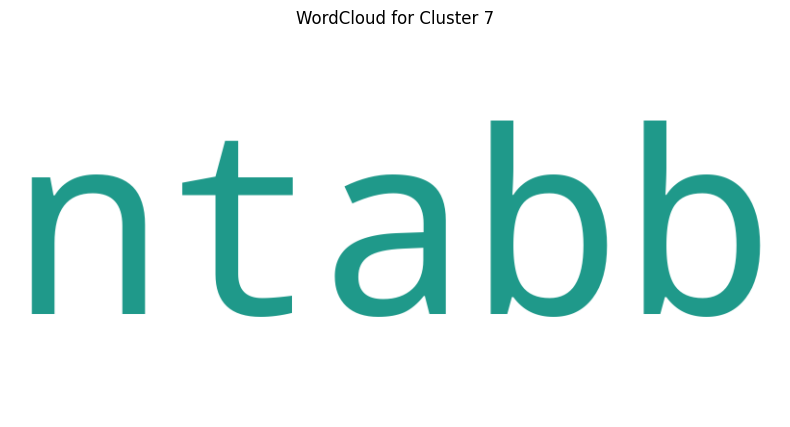

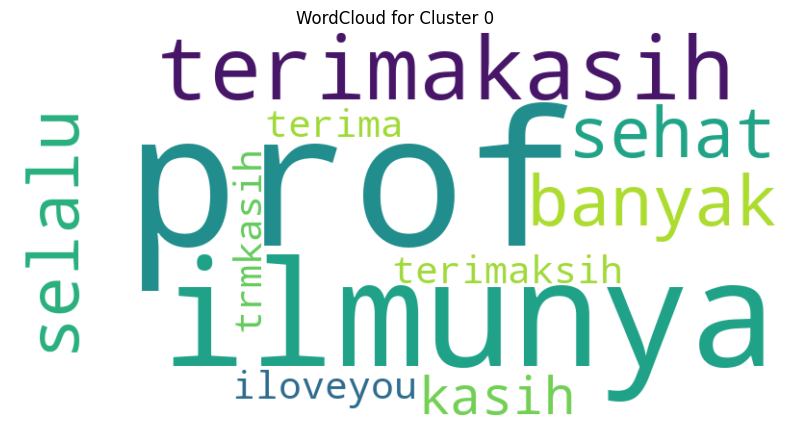

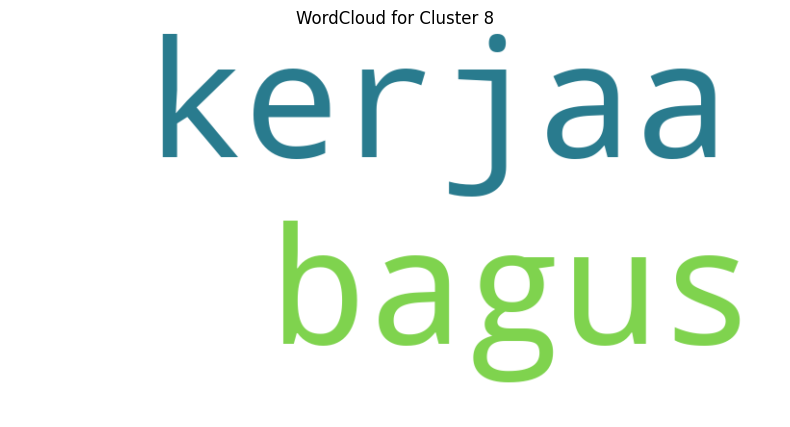

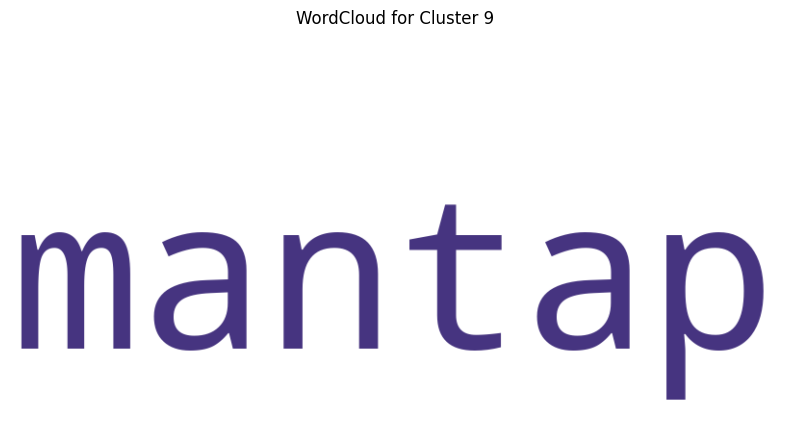

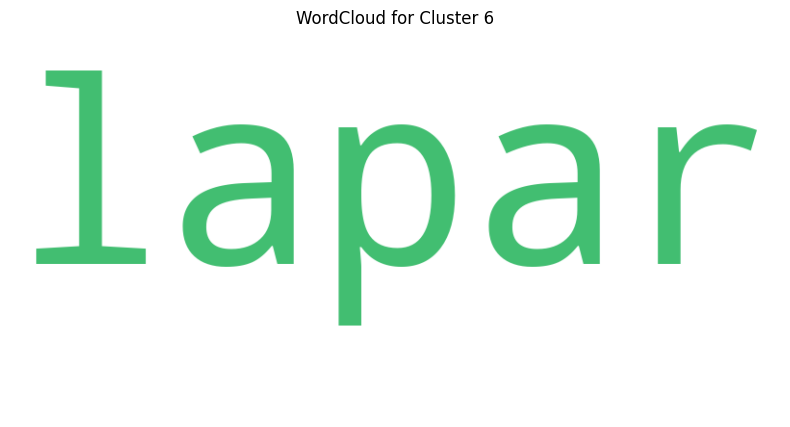


Hasil Persona Analysis TF-IDF Clusters:
Cluster 1: [('digital', 56), ('transformasi', 28), ('indonesia', 23), ('masyarakat', 18), ('sektor', 10), ('pemerintah', 10), ('teknologi', 10), ('juga', 8), ('lebih', 7), ('tantangan', 6)]
Cluster 6: [('sangat', 8), ('bermanfaat', 5), ('digitalisasi', 3), ('pendapat', 2), ('terutama', 2), ('sektor', 2), ('ini', 2), ('keuangan', 2), ('human', 2), ('rural', 2)]
Cluster 0: [('pak', 4), ('tiket', 3), ('prof', 3), ('minta', 3), ('iwan', 2), ('yg', 2), ('industri', 2), ('dirasakan', 2), ('langsung', 2), ('dilakukan', 2)]
Cluster 5: [('single', 2), ('taks', 2)]
Cluster 4: [('digital', 47), ('meningkatkan', 36), ('indonesia', 17), ('teknologi', 15), ('masyarakat', 15), ('lebih', 14), ('transformasi', 13), ('ekonomi', 12), ('literasi', 11), ('infrastruktur', 11)]
Cluster 7: [('nya', 11), ('sering', 5), ('hal', 3), ('keren', 3), ('sdm', 2), ('yg', 2), ('digital', 2), ('dgn', 2), ('banyak', 2), ('contoh', 2)]
Cluster 3: [('prof', 10), ('ilmunya', 8), ('te

In [67]:
# Persona Analysis untuk hasil clustering TF-IDF
print("Persona Analysis untuk TF-IDF Clusters:")
tfidf_personas = analyze_cluster_personas(df, cluster_col='tfidf_cluster', text_col='clean_comments')

# Persona Analysis untuk hasil clustering Word2Vec
print("\nPersona Analysis untuk Word2Vec Clusters:")
word2vec_personas = analyze_cluster_personas(df, cluster_col='word2vec_cluster', text_col='clean_comments')

# Menampilkan hasil dalam bentuk tabel
print("\nHasil Persona Analysis TF-IDF Clusters:")
for cluster, keywords in tfidf_personas.items():
    print(f"Cluster {cluster}: {keywords}")

print("\nHasil Persona Analysis Word2Vec Clusters:")
for cluster, keywords in word2vec_personas.items():
    print(f"Cluster {cluster}: {keywords}")

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [69]:
clean_comments = df['clean_comments'].dropna().tolist()

In [70]:
factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

In [71]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=indonesian_stopwords)
bow_matrix = vectorizer.fit_transform(clean_comments)

In [72]:
num_topics = 5  # Tentative number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(bow_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [73]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_keywords = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = topic_keywords
    return topics

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, feature_names, no_top_words)
for topic, keywords in topics.items():
    print(f"{topic}: {', '.join(keywords)}")

Topic 1: digital, masyarakat, teknologi, indonesia, pemerintah, sektor, pandemi, ekonomi, covid, pembangunan
Topic 2: digital, meningkatkan, transformasi, indonesia, teknologi, nya, kemampuan, masyarakat, ekonomi, pendapatan
Topic 3: digital, prof, ilmunya, terimakasih, banyak, meningkatkan, sangat, penjualan, selalu, transformasi
Topic 4: digital, transformasi, masyarakat, indonesia, literasi, pemerintah, infrastruktur, terutama, menghadapi, sektor
Topic 5: digital, transformasi, indonesia, masyarakat, lebih, pemerintahan, tranformasi, pemerintah, sektor, teknologi


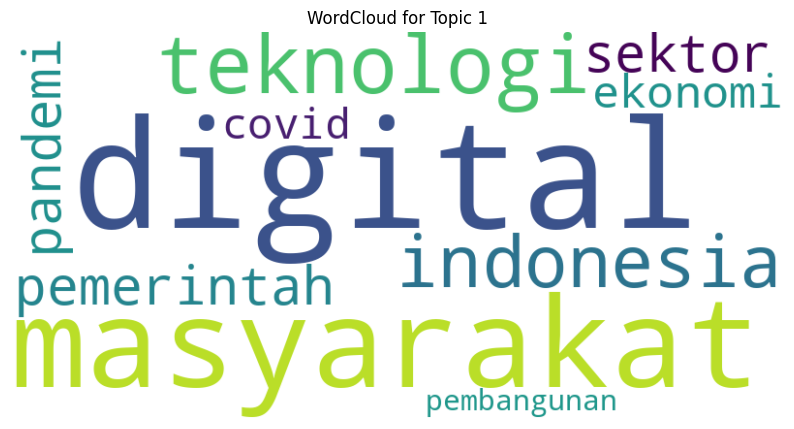

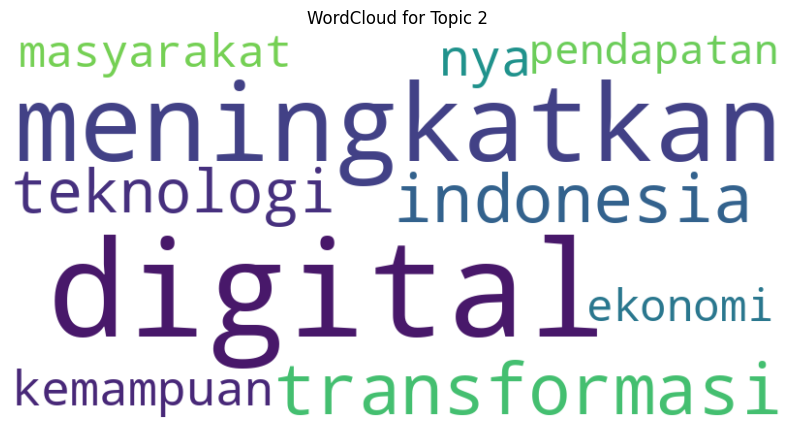

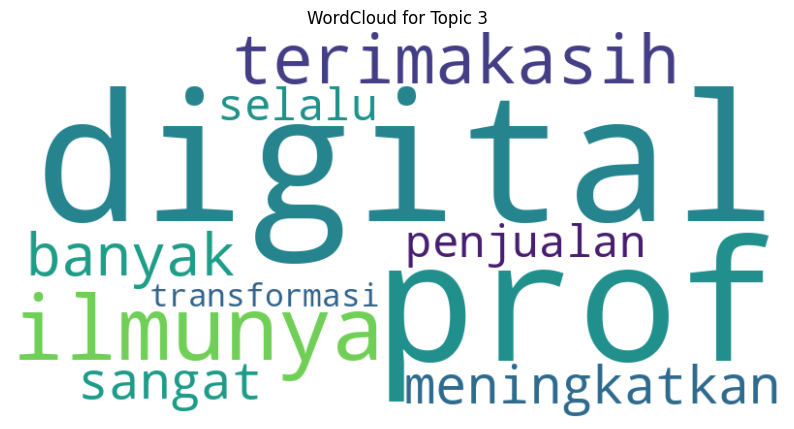

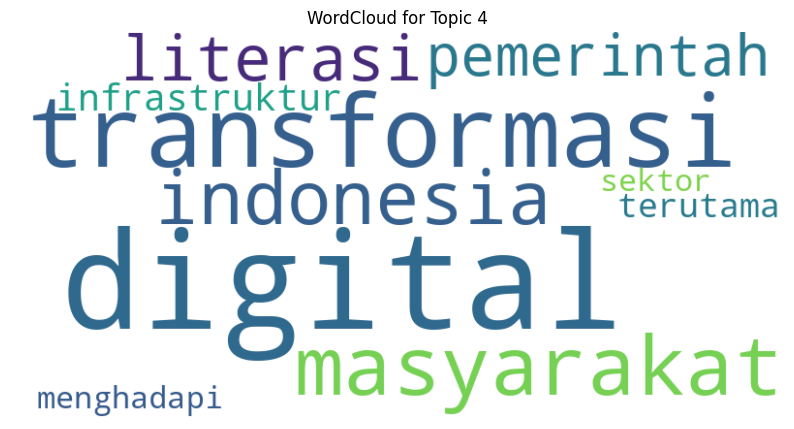

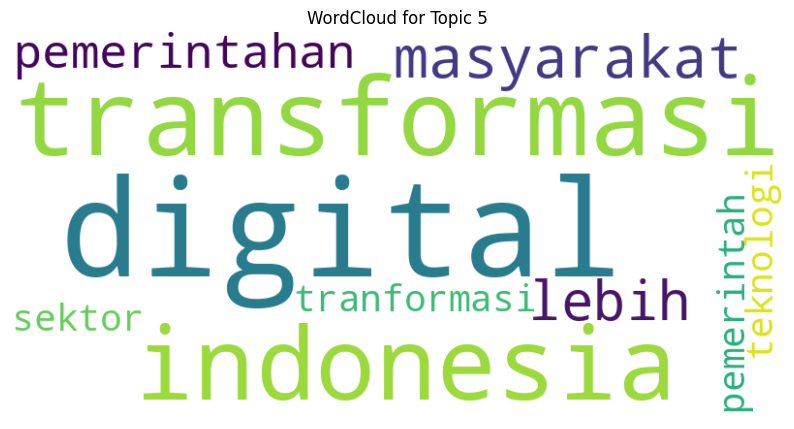

In [74]:
for topic_idx, topic in enumerate(lda_model.components_):
    plt.figure(figsize=(10, 6))
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic {topic_idx+1}")
    plt.show()